In [1]:
include("src/SparseBarratMezard.jl")
using Main.SparseBarratMezard, LinearAlgebra, Plots, LaTeXStrings

## Single Instance Cavity Method

We define a single instance (a particular random matrix) which corresponds to the symmetrized version of the master operator ($M^s$ in the manuscript), with the function `generate_sparse_barrat_matrix(N, c, beta)`. For that the required parameters are:

- N: size of the network.
- c: connectivity.
- beta: inverse of temperature.


The output of this function return the symmetrized matrix, a list of the quenched energies and a list of neighbors for any node in the network.

In [21]:
#Parameters:
N = 1000
c = 5
T = 0.2
beta = 1/T;

In [3]:
Ms, energies, list_neighbors = generate_sparse_barrat_matrix(N,c, beta);

This matrix can be diagonalized using Linear Algebra routines and its spectral density (distribution of eigenvalues) computed as a first approximation. Let us do this

In [11]:
evals = eigvals(Matrix(Ms));

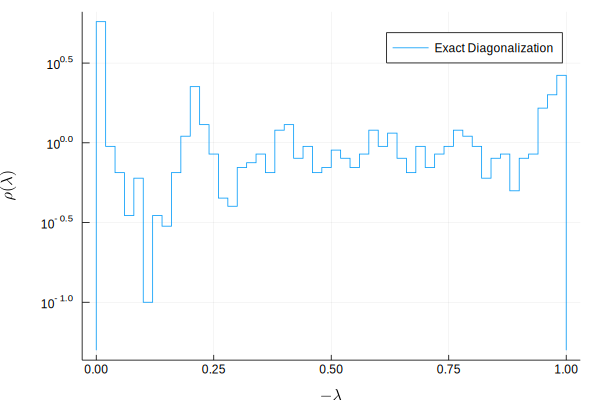

In [40]:
stephist(-evals, xlabel = L"-\lambda", ylabel = L"\rho(\lambda)", 
bins = 50, yscale = :log10, label = "Exact Diagonalization", normed = true)

We compare this result with the estimation obtained from the Cavity Method. For that we provide a lambda grid (points where the cavity equations will be solved and the spectral density evaluated -equations 11, 12 and 13 of the manuscript-) and a value of $\epsilon$ which is the regularization parameter

In [18]:
lambda_grid = collect(-1:0.02:0.);
epsilon = 1e-3

0.001

In [19]:
density = [rho(i, c, beta, epsilon,  energies, list_neighbors) for i in lambda_grid];

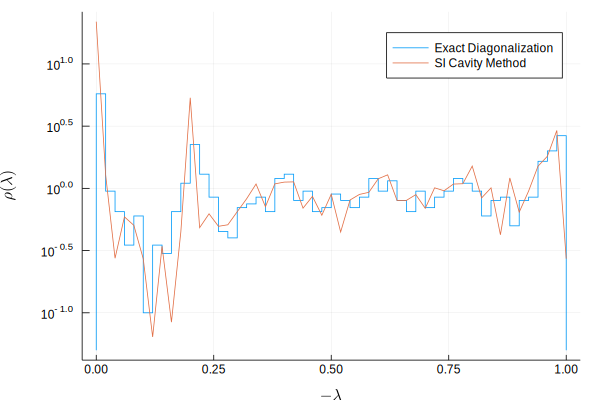

In [41]:
plot!(-lambda_grid, density, yscale = :log10, label = "SI Cavity Method")

As you can see the agreement is not bad, considering that the network size is rather small. It is expected that as the size of the network increases these estimations become smoother. 

## Population Dynamics and Cavity Method

In the limit of $N \rightarrow \infty$ the cavity equations become a self-consistent equation for the joint distribution of energies and cavity precisions (equation 14 of the manuscript). In this scenario what we do is to estimate this distribution using a population dynamics approach, and then draw samples from it in order to estimate the spectral density (equation 16). 

For the estimation of the joint distribution we use the function `generate_population(lambda,c,T,Np, nsteps, epsilon)` which apart from the evident parameters requires:
- Np: size of the population.
- nsteps: number of steps for updating the population.

It has to be checked that the population has reached equilibrium after this function has been executed before proceeding. If this is not the case the function `population_update!` may be applied to the current population. In this example we just assume that equilibrium has been reached.

In [22]:
Np = 100
nsteps = Np*10^4
epsilon0 = 1e-300;

In [23]:
pop = [generate_population(k,c,T,Np, nsteps, epsilon0) for k in lambda_grid]

51-element Array{Main.SparseBarratMezard.Population,1}:
 Main.SparseBarratMezard.Population(Complex{Float64}[4.76587e-298-93.3587im, 1.22092e-295-76646.8im, 1.14466e-299-2.29027im, 8.38015e-299-5.84265im, 7.61217e-299-9.33848im, 1.03985e-299-1.59073im, 1.19643e-298-12.8863im, 7.87902e-295-7.6832e5im, 2.91052e-298-70.058im, 1.18067e-297-117.207im  …  3.10787e-299-4.29265im, 6.81052e-300-1.28122im, 5.13415e-298-28.2548im, 1.29738e-297-78.7311im, 1.48004e-299-1.40966im, 2.87645e-299-2.17982im, 1.88959e-294-1.84562e6im, 8.38264e-299-16.8145im, 3.4333e-297-729.603im, 5.36648e-298-64.6481im], [0.746633, 1.97328, 0.165639, 0.309436, 0.392475, 0.0792288, 0.416765, 2.38862, 0.762355, 0.8595  …  0.2432, 0.0466333, 0.57606, 0.669764, 0.0513062, 0.0957174, 2.56685, 0.539282, 1.18926, 0.653306])
 Main.SparseBarratMezard.Population(Complex{Float64}[97.0076-5.29063e5im, 98.2206-4091.77im, 1.25098-51.6435im, 0.0571643-1.08948im, 0.212833-0.541677im, 13.2094-45.2553im, 9.96468-1.04268e5im, 10.8039-60.9

This object is an array which contains as entries a population of energies and omegas (called zetas in the program) for each lambda. This information is obtained as `pop[i].zetas` or `pop[i].energies`. The index `i` is associated with the lambda in `lambda_grid[i]`.

Finally we evaluate the spectral density by calling the function `DOS(lambda, c, T, Np, ensemble, nsteps,  [epsilon])`. In this function, the argument `ensemble` is the number of samples of the pair $(\Omega_c, E)$ drawn after each further update that we perform on the population, and `[epsilon]` is an array of epsilon values on which we want to evaluate the density.

In [29]:
ensemble = 10^6;

In [31]:
density_pd = [DOS(k, c, T, Np, ensemble, nsteps,[epsilon]) for k in lambda_grid];

In [35]:
dens_array = map(x -> x[1],density_pd);

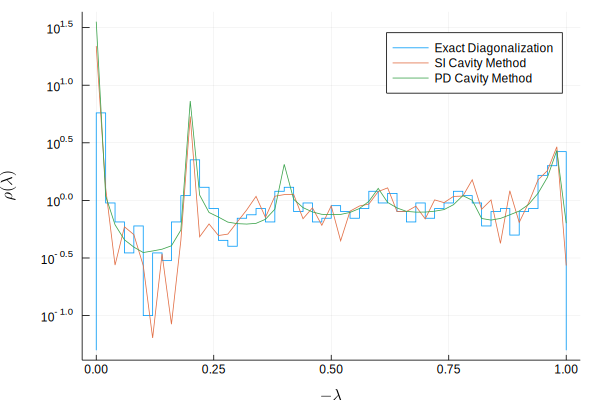

In [42]:
plot!(-lambda_grid, dens_array, yscale = :log10, label = "PD Cavity Method")